In [1]:
import numpy as np
import pandas as pd
import torch.nn as nn
import torch
import os
import random

from functions.parse_data import synth_dataloader
from multivariate_quantile_regression.network_model import QuantileNetwork

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from cot_train.utils import MLP5

2024-04-30 08:25:47.877826: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-30 08:25:47.911519: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-30 08:25:47.911544: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-30 08:25:47.912391: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-30 08:25:47.917835: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    # CUDA is available, so let's set default device to GPU
    torch.set_default_device(0)
    print("CUDA is available. Using GPU.")
else:
    # CUDA is not available, so let's use the CPU
    print("CUDA is not available. Using CPU.")

# Example usage:
tensor = torch.randn(3, 3)  # Create a tensor on the selected device
print("Tensor is on device:", tensor.device)
device = tensor.device

CUDA is available. Using GPU.
Tensor is on device: cuda:0


In [3]:
#Load data and inspect
df = synth_dataloader('SMHIdata2_newsurf')
df.head(10)

,Cloud_B02,Cloud_B03,Cloud_B04,Cloud_B05,Cloud_B06,Cloud_B07,Cloud_B08,Cloud_B08A,Cloud_B09,Cloud_B10,...,Clear_B11,Clear_B12,Sat_Zenith_Angle,Sun_Zenith_Angle,Azimuth_Diff_Angle,COT,Cloud_Type,Profile_ID,GOT,Water_Vapor
0,0.57804,0.51792,0.54680,0.56000,0.56824,0.57365,0.56583,0.57950,0.37962,0.01949,...,0.04745,0.03758,9.00,68.68,48.59,25.181,3,9543,0.122,0.56
1,0.28975,0.25479,0.29171,0.32868,0.40295,0.44817,0.45809,0.50999,0.17019,0.00067,...,0.75602,0.58746,1.60,73.05,176.23,1.730,2,3672,0.116,0.77
2,0.71170,0.68907,0.73376,0.76922,0.81416,0.83261,0.83383,0.85262,0.63399,0.10050,...,0.65577,0.52408,14.75,42.45,16.45,20.746,4,3564,0.124,0.23
3,0.30316,0.32260,0.39997,0.43564,0.48821,0.52882,0.53207,0.58302,0.22735,0.00072,...,0.87771,0.74346,7.49,55.96,96.60,0.721,1,2993,0.122,0.83
4,0.84968,0.80047,0.83504,0.80686,0.83849,0.86902,0.80830,0.88989,0.26912,0.00051,...,0.81451,0.56093,1.45,51.76,79.44,49.984,3,6226,0.127,4.57
5,0.47968,0.45684,0.48555,0.50933,0.63299,0.71180,0.65449,0.78567,0.27385,0.01380,...,0.91439,0.60915,9.17,64.44,87.17,11.128,2,5251,0.128,4.42
6,0.31475,0.34345,0.35773,0.44913,0.72468,0.78040,0.75561,0.80269,0.34052,0.00156,...,0.90172,0.66072,10.77,68.43,122.12,4.445,1,6703,0.080,0.71
7,0.71760,0.68823,0.71453,0.72291,0.81518,0.87488,0.82043,0.93069,0.37696,0.04403,...,0.94217,0.81028,10.29,41.28,9.38,22.209,5,3031,0.128,2.78
8,0.63913,0.63027,0.67796,0.71480,0.81141,0.86388,0.85365,0.89979,0.65188,0.33643,...,0.89019,0.62145,7.52,48.72,141.93,18.855,4,8434,0.101,0.58
9,0.24895,0.24306,0.24877,0.31625,0.51416,0.57959,0.58756,0.64406,0.27037,0.00287,...,0.75560,0.52477,13.00,67.88,100.70,0.664,5,2395,0.124,0.57


In [4]:
#Set columns for X and y (input/output features)
X_cols = ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06',
          'Cloud_B07','Cloud_B08','Cloud_B08A','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Sun_Zenith_Angle']
y_cols = ['Clear_B02','Clear_B03','Clear_B04','Clear_B05','Clear_B06',
          'Clear_B07','Clear_B08','Clear_B08A','Clear_B09','Clear_B10','Clear_B11','Clear_B12']

#Find X and y
X=df[X_cols]
y=df[y_cols]


In [5]:
#Set up paths for importing COT est models
#COT_model_paths = ['smhi_models3/0/model_it_2000000','smhi_models3/1/model_it_2000000','smhi_models3/2/model_it_2000000','smhi_models3/3/model_it_2000000','smhi_models3/4/model_it_2000000',
#                   'smhi_models3/5/model_it_2000000','smhi_models3/6/model_it_2000000','smhi_models3/7/model_it_2000000','smhi_models3/8/model_it_2000000','smhi_models3/9/model_it_2000000']

COT_model_paths = ['smhi_models4/0/model_it_2000000','smhi_models4/1/model_it_2000000','smhi_models4/2/model_it_2000000','smhi_models4/3/model_it_2000000','smhi_models4/4/model_it_2000000']



#Initialize and load COT estimation models
COT_est_models = [MLP5(13, 1, apply_relu=True) for _ in range(len(COT_model_paths))]
for i,model in enumerate(COT_est_models):
    model.load_state_dict(torch.load(COT_model_paths[i],map_location=device))

#Create X for COT estimation
X_COTest = X.to_numpy()
#Add noise for fairness
X_COTest= X_COTest + np.random.randn(np.shape(X_COTest)[0],np.shape(X_COTest)[1]) * np.mean(X_COTest,axis=0)*0.03
#Normalize and turn into tensor before input
X_COTest_mu = np.mean(X_COTest,axis=0)
X_COTest_std = np.std(X_COTest,axis=0)
X_COTest_norm = (X_COTest-X_COTest_mu)/X_COTest_std
tX_COTest_norm = torch.Tensor(X_COTest_norm).to(device)
#Make predictions (*50 to denormalize predictions)
COT_preds_total = []
for i,model in enumerate(COT_est_models):
    COT_preds = 50*model(tX_COTest_norm).cpu().detach().numpy()
    #Keep track of ensemble prediction
    if i==0:
        COT_preds_total=COT_preds
    else:
        COT_preds_total=COT_preds_total+COT_preds

COT_preds_total = COT_preds_total/len(COT_est_models)

#Sort into categories instead
t_is_cloud = 0.025*50 #From Pirinen et. al.
t_thin_cloud = 0.015*50 #From Pirinen et. al.

pred_clear = np.zeros(COT_preds_total.shape)
pred_thin = np.zeros(COT_preds_total.shape)
pred_thick = np.zeros(COT_preds_total.shape)

pred_clear[COT_preds_total<t_thin_cloud]=1
pred_thin[(COT_preds_total>=t_thin_cloud)&(COT_preds_total<t_is_cloud)]=1
pred_thick[COT_preds_total>=t_is_cloud]=1

#Create new X including COT dummies
X = X.assign(Clear=pred_clear[:,0])
X = X.assign(Thin=pred_thin[:,0])
X = X.assign(Thick=pred_thick[:,0])

#Update X_cols
X_cols = ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06',
          'Cloud_B07','Cloud_B08','Cloud_B08A','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12',
          'Sun_Zenith_Angle','Clear','Thin','Thick']

#Separate testdata from rest for 80/10/10 Train/Val/Test split
X_trainval, X_test, y_trainval, y_test=train_test_split(X,y,test_size=0.1,random_state=313)

#Find clear indices in trainval
clear_indices = np.array([])
for i,df_idx in enumerate(X_trainval.index):
    if df['Cloud_Type'][df_idx]==0:
        clear_indices=np.append(clear_indices,i)

#Add noise to X_test, 0 mean with stdev equal to 3% of mean of each feature
np.random.seed(313)
X_test.iloc[:,:13] = X_test.iloc[:,:13] + np.random.randn(np.shape(X_test)[0],np.shape(X_test)[1]-3) * np.mean(X.iloc[:,:13].to_numpy(),axis=0)*0.03

In [6]:
#Choose if to save models and data, if so set path
save = True
if save:
    test_name = "Final_model_newsurf_w_clear_noise"
    main_filepath = 'pytorch_models/'+test_name

#Set up which quantiles to estimate, and find index of estimator (q=0.5)
quantiles=np.array([0.1,0.5,0.9])
est= np.where(quantiles==0.5)[0].item()

#Set up algorithm parameters
val_size=0.1
num_models=5
batch_size=500
nepochs=1000
lr=0.002
noise_ratio = 0.03
early_break=True
no_nodes = 200
clear_noise=True

#Create network
sequence= lambda: nn.Sequential(
    nn.Linear(len(X_cols),no_nodes),
    nn.ReLU(),
    nn.BatchNorm1d(no_nodes),
    nn.Linear(no_nodes,no_nodes),
    nn.ReLU(),
    nn.BatchNorm1d(no_nodes),
    nn.Linear(no_nodes,no_nodes),
    nn.ReLU(),
    nn.BatchNorm1d(no_nodes),
    nn.Linear(no_nodes,no_nodes),
    nn.ReLU(),
    nn.BatchNorm1d(no_nodes),
    nn.Linear(no_nodes, len(quantiles)*len(y_cols)) #Output dimesion is number of quantiles times number of target variables
)

#Initalize models
models = [QuantileNetwork(quantiles=quantiles) for _ in range(num_models)]

#Train models
for i,model in enumerate(models):
    #Find new train/val splits for each model for robustness
    validation_indices=np.array(random.sample(range(len(X_trainval['Cloud_B02'])), int(len(X['Cloud_B02'])*val_size)))
    train_indices=[i for i in range(len(X_trainval['Cloud_B02'])) if np.any(validation_indices==i)==False]  
    #Fit model with X
    model.fit(X_trainval.to_numpy(),y_trainval.to_numpy(), 
            train_indices=train_indices, 
            validation_indices=validation_indices, 
            batch_size=batch_size,
            nepochs=nepochs,
            sequence=sequence(),
            lr=lr,
            noise_ratio=noise_ratio,
            early_break=early_break,
            clear_noise=clear_noise,
            clear_indices=clear_indices)
    
    #Save models if wanted
    if save:
        filepath=main_filepath+'/model'+str(i)
        os.makedirs(filepath,exist_ok=True)
        torch.save(model,filepath+'/model_file')

#Finally save data if wanted
if save: 
    filepath=main_filepath+'/data'
    os.makedirs(filepath,exist_ok=True)
    #Save datasplits
    X_trainval.to_csv(filepath+'/X_trainval.csv')
    y_trainval.to_csv(filepath+'/y_trainval.csv')
    X_test.to_csv(filepath+'/X_test.csv')
    y_test.to_csv(filepath+'/y_test.csv')

Epoch 571


Batch number: 100%|██████████| 320/320 [00:01<00:00, 311.07it/s]

Training loss [2.4499207] Validation loss [2.470268]
Epoch 572



Batch number: 100%|██████████| 320/320 [00:01<00:00, 311.57it/s]

Training loss [2.4525235] Validation loss [2.463139]
Epoch 573



Batch number: 100%|██████████| 320/320 [00:01<00:00, 311.91it/s]

Training loss [2.4454553] Validation loss [2.4686909]
Epoch 574



Batch number: 100%|██████████| 320/320 [00:01<00:00, 311.92it/s]

Training loss [2.4517632] Validation loss [2.453895]
Epoch 575



Batch number: 100%|██████████| 320/320 [00:01<00:00, 310.89it/s]

Training loss [2.4525862] Validation loss [2.4505024]
Epoch 576



Batch number: 100%|██████████| 320/320 [00:01<00:00, 311.95it/s]

Training loss [2.451063] Validation loss [2.4760377]


---No improvement in 100 epochs, broke early---
Best model out of total max epochs found at epoch 476
With validation loss: 2.4354865550994873


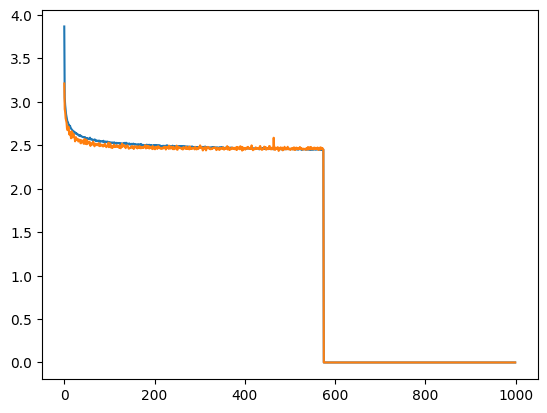

In [7]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(model.train_loss.cpu())
plt.plot(model.val_loss.cpu())
plt.show()